In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [4]:


# Custom Dataset
class FashionDataset(Dataset):
    def __init__(self, person_img_paths, cloth_img_paths, transform=None):
        valid_indices = []
        for i in range(len(person_img_paths)):
            if os.path.exists(person_img_paths[i]) and os.path.exists(cloth_img_paths[i]):
                valid_indices.append(i)

        self.person_img_paths = [person_img_paths[i] for i in valid_indices]
        self.cloth_img_paths = [cloth_img_paths[i] for i in valid_indices]
        self.transform = transform

    def __len__(self):
        return len(self.person_img_paths)

    def __getitem__(self, idx):
        person_path = self.person_img_paths[idx]
        cloth_path = self.cloth_img_paths[idx]

        try:
            person_img = Image.open(person_path).convert("RGB")
            cloth_img = Image.open(cloth_path).convert("RGB")
        except Exception as e:
            print(f"Error loading images: {e}")
            return None, None

        if self.transform:
            person_img = self.transform(person_img)
            cloth_img = self.transform(cloth_img)

        return person_img, cloth_img

# Warping Network
class WarpingNetwork(nn.Module):
    def __init__(self):
        super(WarpingNetwork, self).__init__()
        self.warp = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, person_img, cloth_img):
        x = torch.cat([person_img, cloth_img], dim=1)
        warped_cloth = self.warp(x)
        return warped_cloth

# GAN for blending
class TryOnGAN(nn.Module):
    def __init__(self):
        super(TryOnGAN, self).__init__()
        self.generator = nn.Sequential(
            nn.Conv2d(6, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.4),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.4),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.4),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.4),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
            nn.Sigmoid()
        )

    def generate(self, person_img, warped_cloth):
        x = torch.cat((person_img, warped_cloth), dim=1)
        return self.generator(x)

    def discriminate(self, tryon_img):
        return self.discriminator(tryon_img)

# Dataset and Dataloader
dataset_folder = "test/classified"
person_folder = os.path.join(dataset_folder, 'person')
cloth_folder = os.path.join(dataset_folder, 'cloth')

person_img_paths = [os.path.join(person_folder, img) for img in os.listdir(person_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
cloth_img_paths = [os.path.join(cloth_folder, img) for img in os.listdir(cloth_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total person images: {len(person_img_paths)}")
print(f"Total cloth images: {len(cloth_img_paths)}")

dataset = FashionDataset(person_img_paths, cloth_img_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
print(f"Loaded dataset with {len(dataset)} images.")

# Initialize models and optimizers
warp_net = WarpingNetwork().to(device)
gan_net = TryOnGAN().to(device)

warp_optimizer = optim.Adam(warp_net.parameters(), lr=0.0001)
gen_optimizer = optim.Adam(gan_net.generator.parameters(), lr=0.0001)
disc_optimizer = optim.Adam(gan_net.discriminator.parameters(), lr=0.0001)

# Loss functions
bce_loss = nn.BCELoss()

Total person images: 236
Total cloth images: 236
Loaded dataset with 236 images.


In [6]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# Initialize loss tracking
disc_losses = []
gen_losses = []

# Metrics tracking
precision_vals = []
recall_vals = []
f1_vals = []
accuracy_vals = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    epoch_disc_loss = 0.0
    epoch_gen_loss = 0.0

    y_true, y_pred = [], []

    for batch in tqdm(dataloader):
        person_img, cloth_img = batch

        if person_img is None or cloth_img is None:
            continue

        person_img, cloth_img = person_img.to(device), cloth_img.to(device)

        # Warp the cloth
        warped_cloth = warp_net(person_img, cloth_img)

        # Generate try-on output
        fake_tryon = gan_net.generate(person_img, warped_cloth)

        # Train Discriminator
        disc_optimizer.zero_grad()
        real_labels = torch.ones(person_img.size(0), 1, device=device)
        fake_labels = torch.zeros(person_img.size(0), 1, device=device)

        real_loss = bce_loss(gan_net.discriminate(person_img), real_labels)
        fake_loss = bce_loss(gan_net.discriminate(fake_tryon.detach()), fake_labels)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # Train Generator
        gen_optimizer.zero_grad()
        gen_loss = bce_loss(gan_net.discriminate(fake_tryon), real_labels)
        gen_loss.backward()
        gen_optimizer.step()

        # Collect metrics
        y_true += real_labels.cpu().numpy().tolist()
        y_pred += (gan_net.discriminate(fake_tryon) > 0.5).cpu().numpy().tolist()

        epoch_disc_loss += disc_loss.item()
        epoch_gen_loss += gen_loss.item()

    # Calculate metrics
    precision_vals.append(precision_score(y_true, y_pred))
    recall_vals.append(recall_score(y_true, y_pred))
    f1_vals.append(f1_score(y_true, y_pred))
    accuracy_vals.append(accuracy_score(y_true, y_pred))

    # Log losses
    avg_disc_loss = epoch_disc_loss / len(dataloader)
    avg_gen_loss = epoch_gen_loss / len(dataloader)
    disc_losses.append(avg_disc_loss)
    gen_losses.append(avg_gen_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Discriminator Loss: {avg_disc_loss:.4f}, Generator Loss: {avg_gen_loss:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.17it/s]


Epoch [1/10] - Discriminator Loss: 1.9377, Generator Loss: 1.6073


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.15it/s]


Epoch [2/10] - Discriminator Loss: 1.0965, Generator Loss: 0.8947


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.25it/s]


Epoch [3/10] - Discriminator Loss: 1.4669, Generator Loss: 1.3121


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.40it/s]


Epoch [4/10] - Discriminator Loss: 1.7003, Generator Loss: 1.0676


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch [5/10] - Discriminator Loss: 1.0276, Generator Loss: 1.6652


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [6/10] - Discriminator Loss: 1.6234, Generator Loss: 1.7963


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.34it/s]


Epoch [7/10] - Discriminator Loss: 1.5124, Generator Loss: 1.7410


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.38it/s]


Epoch [8/10] - Discriminator Loss: 0.8980, Generator Loss: 1.6403


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.37it/s]


Epoch [9/10] - Discriminator Loss: 1.2331, Generator Loss: 1.1277


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:12<00:00,  2.33it/s]

Epoch [10/10] - Discriminator Loss: 1.1525, Generator Loss: 1.4837


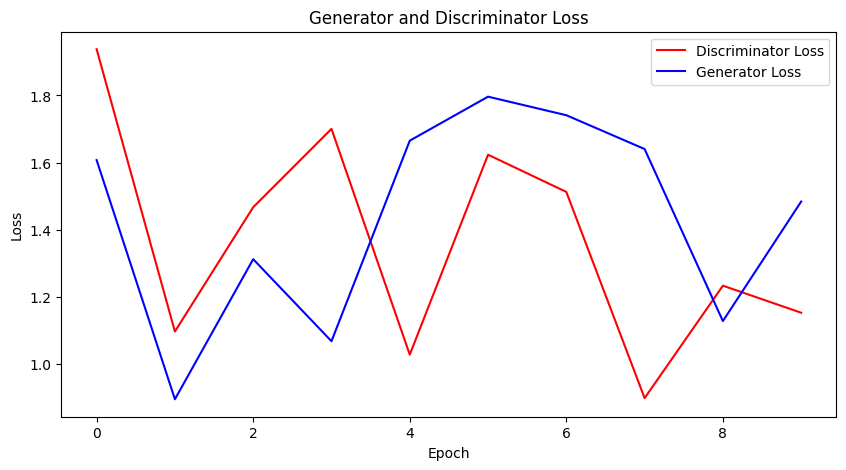

In [7]:


# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(disc_losses, label='Discriminator Loss', color='red')
plt.plot(gen_losses, label='Generator Loss', color='blue')
plt.title('Generator and Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

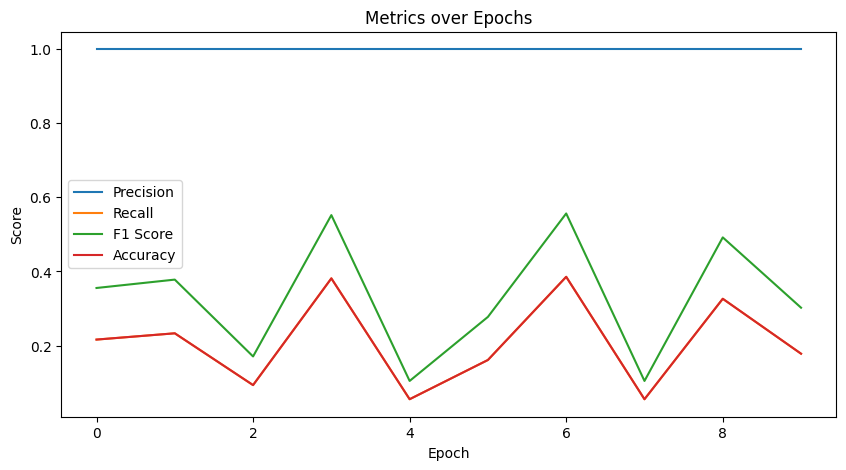

In [8]:


# Plot Metrics
plt.figure(figsize=(10, 5))
plt.plot(precision_vals, label='Precision')
plt.plot(recall_vals, label='Recall')
plt.plot(f1_vals, label='F1 Score')
plt.plot(accuracy_vals, label='Accuracy')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


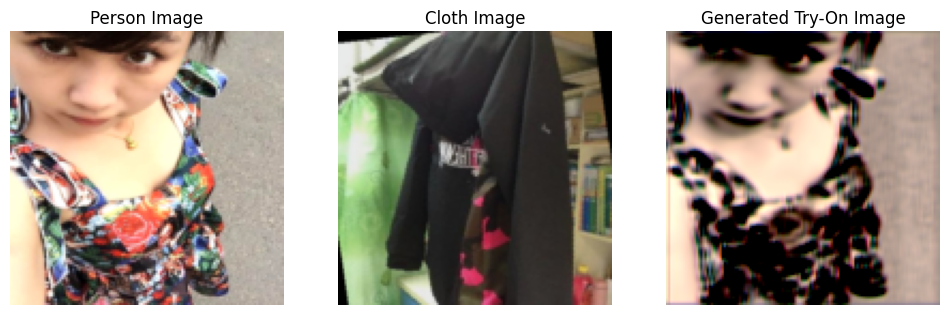

In [11]:
# Visualize results after training
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def visualize_results(person_img, cloth_img, generated_img):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(person_img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[0].set_title("Person Image")
    axes[1].imshow(cloth_img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[1].set_title("Cloth Image")
    axes[2].imshow(generated_img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    axes[2].set_title("Generated Try-On Image")
    for ax in axes:
        ax.axis("off")
    plt.show()
count = 0
# Display a few examples
with torch.no_grad():
    for person_img, cloth_img in dataloader:
        if person_img is None or cloth_img is None:
            continue
        person_img, cloth_img = person_img.to(device), cloth_img.to(device)
        warped_cloth = warp_net(person_img, cloth_img)
        fake_tryon = gan_net.generate(person_img, warped_cloth)
        visualize_results(person_img[0], cloth_img[0], fake_tryon[0])
        break# Show only one example

In [12]:
# Print Final Metrics and Losses
print("\nFinal Metrics and Losses:")
print(f"Final Precision: {precision_vals[-1]:.4f}")
print(f"Final Recall: {recall_vals[-1]:.4f}")
print(f"Final F1-Score: {f1_vals[-1]:.4f}")
print(f"Final Accuracy: {accuracy_vals[-1]:.4f}")
print(f"Final Discriminator Loss: {disc_losses[-1]:.4f}")
print(f"Final Generator Loss: {gen_losses[-1]:.4f}")



Final Metrics and Losses:
Final Precision: 1.0000
Final Recall: 0.1780
Final F1-Score: 0.3022
Final Accuracy: 0.1780
Final Discriminator Loss: 1.1525
Final Generator Loss: 1.4837
